<a href="https://colab.research.google.com/github/AashiDutt/AI-and-ML-for-Coders/blob/main/Chapter_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab contains code for:

1. Using convolutions for sequence data

In [15]:
# Creating windowed dataset

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [4]:
dataset = tf.data.Dataset.range(10) #dataset contains values from 0 to n-1 (n = 10)

#split dataset into windows of 5 items, then shift window by 1, 
#drop_remainder - when window reaches end and items in window are less than 5, they should be dropped
dataset = dataset.window(5, shift = 1, drop_remainder = True)

#split dataset into batch of 5 windows
dataset = dataset.flat_map(lambda window:window.batch(5))

#split each window into everything before the last value and then last value
dataset = dataset.map(lambda window:(window[:-1], window[-1:]))

dataset = dataset.shuffle(buffer_size = 10)
dataset = dataset.batch(2).prefetch(1)

#This gives x and y dataset
for x, y in dataset:
  print("x = ",x.numpy()) 
  print("y = ",y.numpy())

x =  [[2 3 4 5]
 [1 2 3 4]]
y =  [[6]
 [5]]
x =  [[5 6 7 8]
 [3 4 5 6]]
y =  [[9]
 [7]]
x =  [[4 5 6 7]
 [0 1 2 3]]
y =  [[8]
 [4]]


In [6]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time, slope) 
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)


In [14]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
# Creating function for generating windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series= tf.expand_dims(series, axis = -1) #dataset created needs to be defined as 1D Tensor

#from_tensor_slices - turn series into dataset  
  dataset = tf.data.Dataset.from_tensor_slices(series)

  dataset = dataset.window(window_size + 1, shift=1,drop_remainder=True)

  dataset = dataset.flat_map(lambda window:window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1], window[-1]))

  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

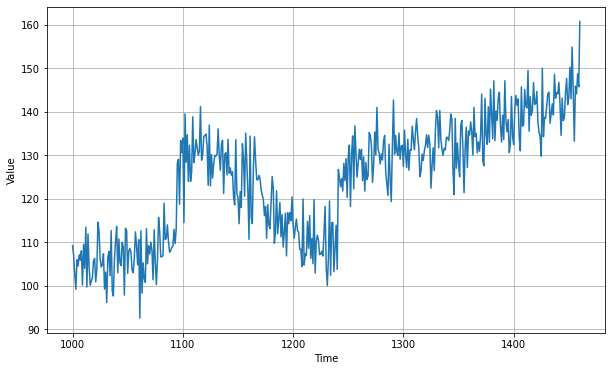

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [17]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 1s 5ms/step - loss: 536.5720
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 115.2625
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 93.3957
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 81.4062
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 75.5818
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 72.1894
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 69.8970
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 69.0632
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 68.0582
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 67.7551
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 67.0888
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 66.4118
Epoch 13/100
31/31 [===============

In [20]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [21]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)

results = forecast[split_time - window_size:-1,-1,0]

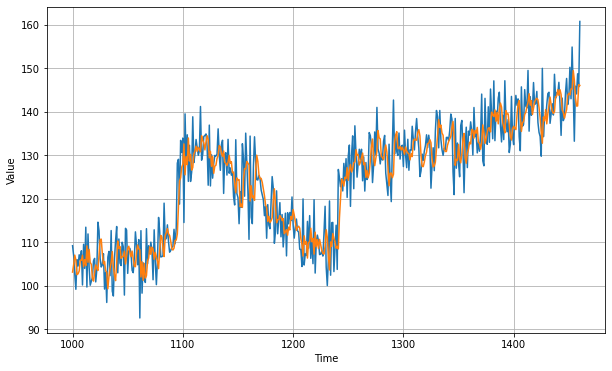

In [22]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.622004